# DS 552 - Generative AI
## Homework 4 - Kevin Metzler

## Question 1

### Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.
The minimax loss function in GANs is defined as:
$$ \min_G \max_D \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))] $$

The Generator (G) tries to generate data that is indistinguishable from real data, while the Discriminator (D) tries to distinguish between real data and generated data.

The minimax loss ensures competitive training by encouraging the generator to produce more realistic data to fool the discriminator, while encouraging the discriminator to become better at distinguishing real data from generated data.

### Q2: What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?
Mode collapse occurs when the generator produces limited diversity in its outputs, often generating the same or similar outputs for different inputs. This can be caused by the generator finding a few modes that successfully fool the discriminator and generating those modes and nothing else. Another possiblity is the discriminator may not penalize the lack of diversity in generation effectively.

To mitigate this we can use Unrolled GANs, which temporarily unroll the optimization of the discriminator to provide more informative gradients to the generator. Also, mini-batch discrimination encourages the generator to produce diverse outputs by comparing batches of generated data to one another. Feature matching uses intermediate layer features of the discriminator to guide the generator to produce mroe diverse output.

### Q3: Explain the role of the discriminator in adversarial training?
The discriminator in adversarial training acts as a binary classifier that distinguishes between real and generated data. This provides feedback to the generator on how realistic the generated data is. It also helps improve the generator by providing gradients that guide the generator to produce more realistic data.

### Q4: How do metrics like IS and FID evaluate GAN performance?
Inception Score (IS) measures the quality and diversity of generated images. High IS indicates that generated images are both high-quality and diverse. IS can be computed using a pre-trained Inception network to classify generated images.

Fréchet Inception Distance (FID) measures the distance between the distributions of real and generated images. Lower FID indicates that the generated images are closer to the real images in terms of distribution. This can be computed using the mean and covariance of features extracted from a pre-trained Inception network.

## Coding Assignment

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

# Directory to save generated images
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

def save_images(epoch, test_input):
    predictions = generator(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('generated_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_images(epoch + 1, seed)

# Run the training
train(train_dataset, epochs=500)

## MNIST Dataset
### 10 epochs
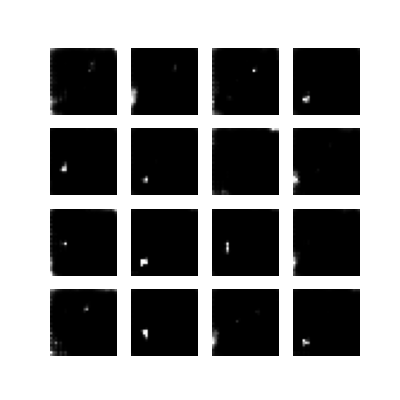

### 20 epochs
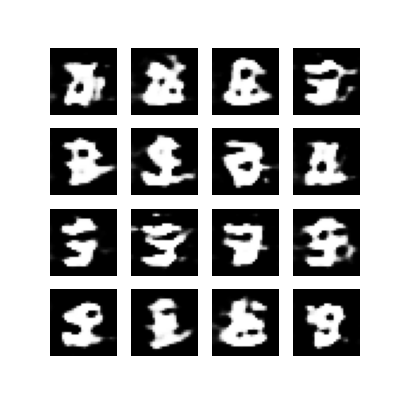

### 30 epochs
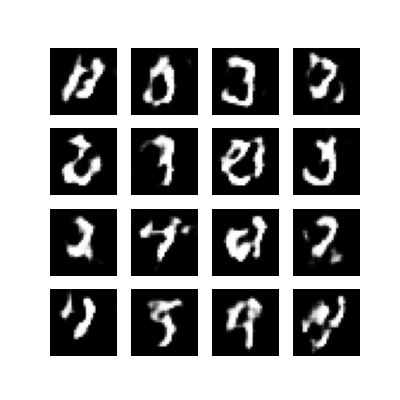

### 40 epochs
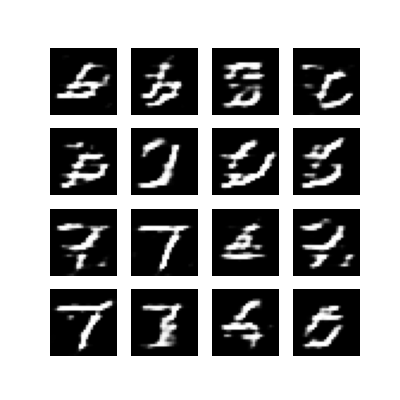

### 50 epochs
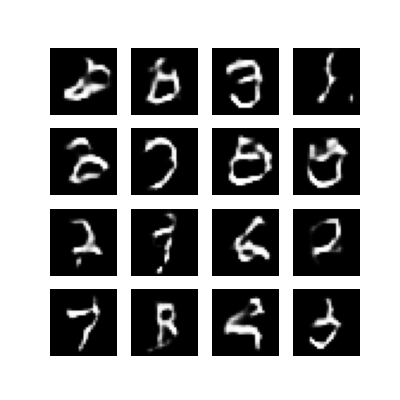


In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

# Directory to save generated images
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

def save_images(epoch, test_input):
    predictions = generator(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5))
        plt.axis('off')

    plt.savefig('generated_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-4)

# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_images(epoch + 1, seed)

# Run the training
train(train_dataset, epochs=200)

E0000 00:00:1738880029.275878 2783678 meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/sequential_19_1/leaky_re_lu_67_1/LeakyRelu/LeakyReluGrad' exist for missing node 'sequential_19_1/conv2d_22_1/BiasAdd'.
2025-02-06 17:18:36.117961: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## CIFAR10 Dataset
### 10 epochs
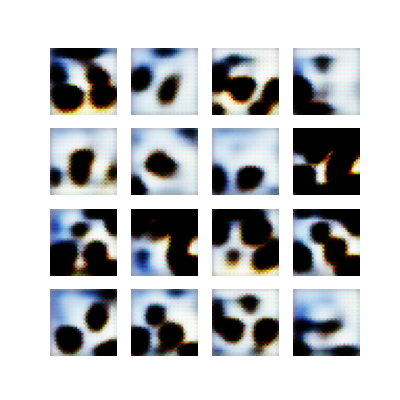

### 20 epochs
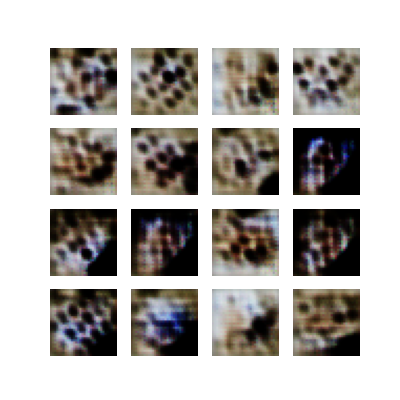

### 30 epochs
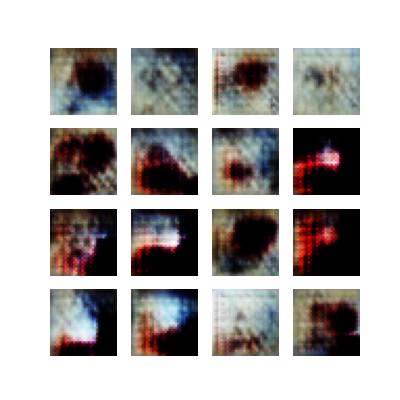

### 40 epochs
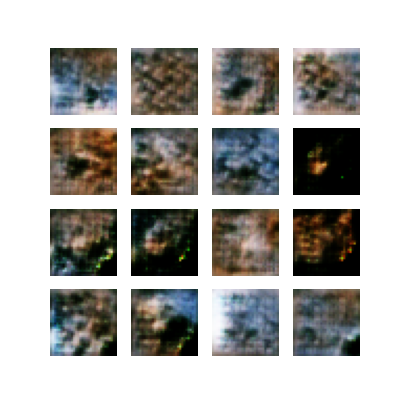

### 50 epochs
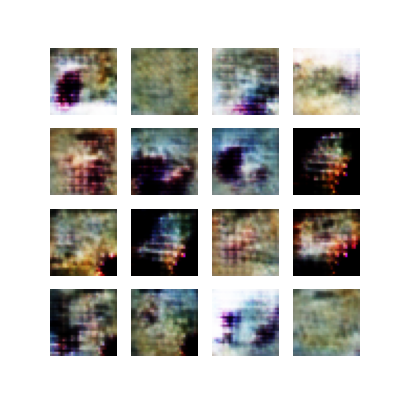

### 60 epochs
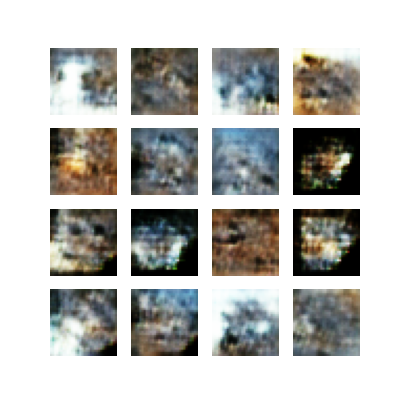

### 70 epochs
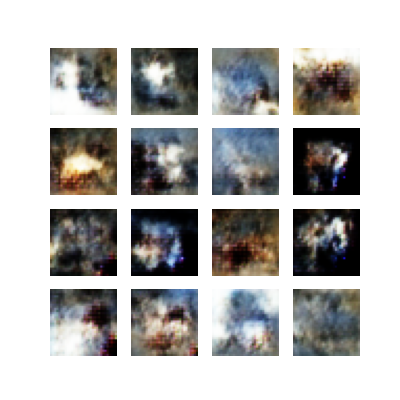

### 80 epochs
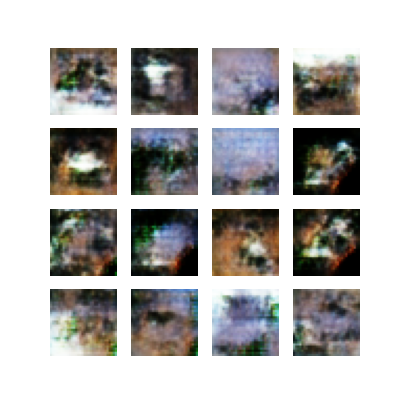

### 90 epochs
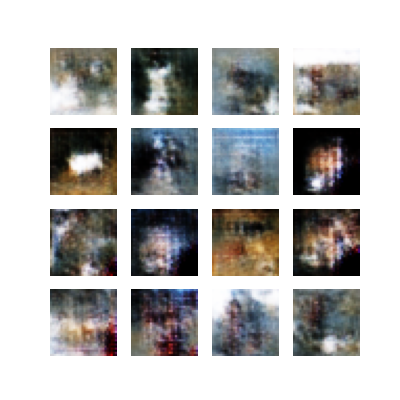

### 100 epochs
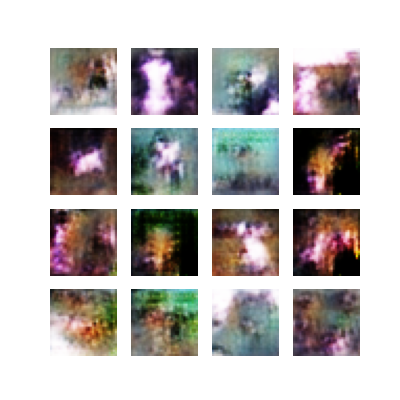

### 110 epochs
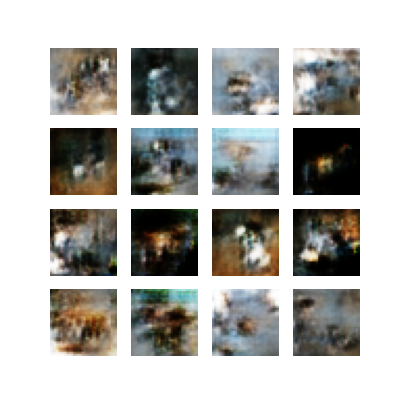

### 120 epochs
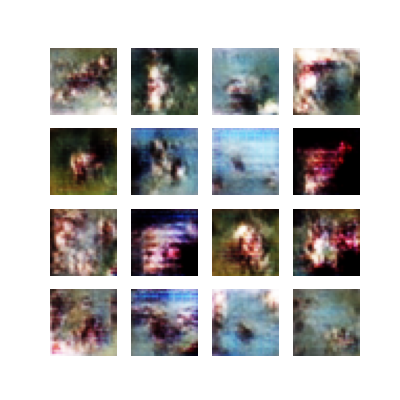

### 130 epochs
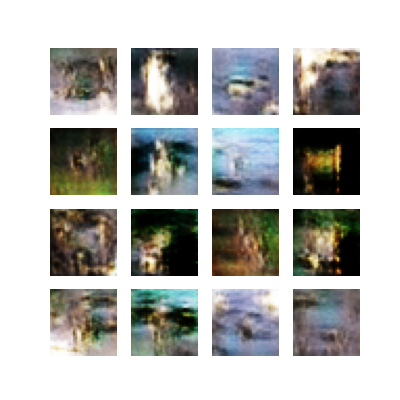

### 140 epochs
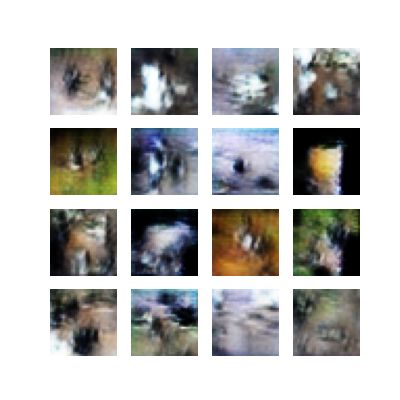

### 150 epochs
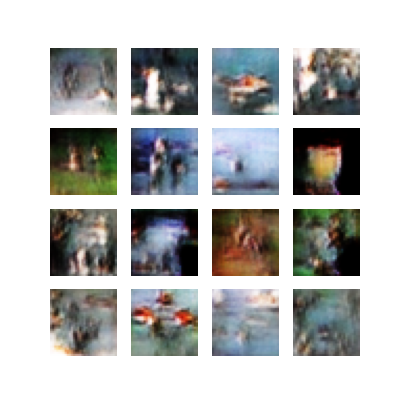

### 160 epochs
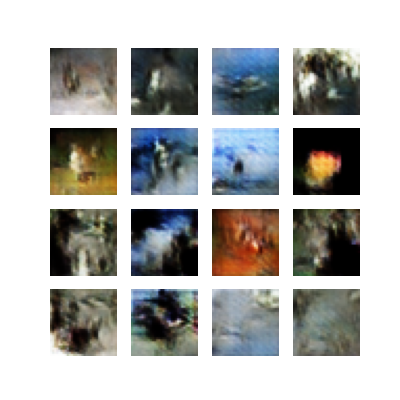

### 170 epochs
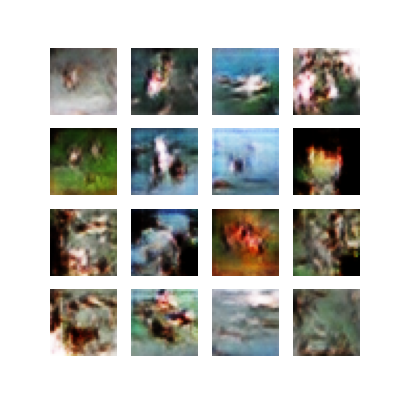

### 180 epochs
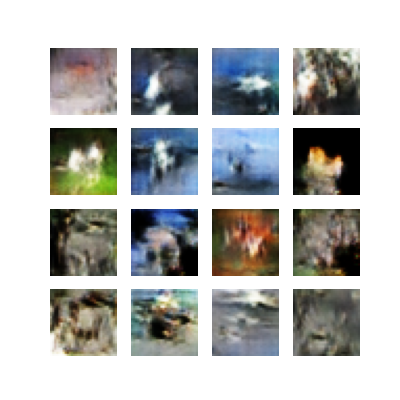

### 190 epochs
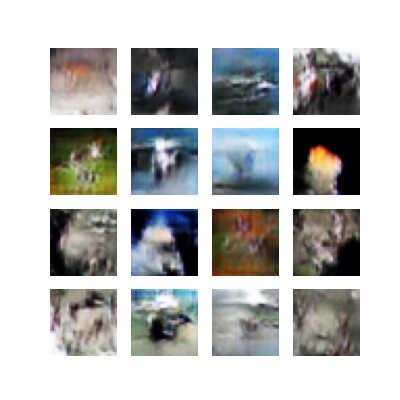

### 200 epochs
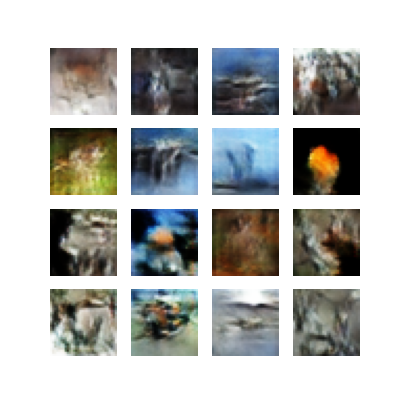